# This is going to be the final notebook to present all findings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import src.visualization as vs
import src.process as process
import models.lib as modlib

# processing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, cross_validate, KFold
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score, fbeta_score, recall_score, precision_score
from sklearn.metrics import classification_report, roc_curve, confusion_matrix

# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB,GaussianNB

# ignore all warnings
import warnings
warnings.filterwarnings('ignore')

from xgboost import XGBClassifier

RSEED = 42

In [2]:
data = pd.read_csv('data/processed/kickstarter_clean.csv')

In [3]:
vs.nice_summary(data)

,Columns,Dtype,nunique,Non-Null Count,Missing,Missing %,Zero Count,mean,std,min,25%,50%,75%,max
0,backers_count,int64,3206,192664,-,-,15009,152.56,898.35,0.0,4.0,30.0,94.25,105857.0
1,country,object,22,192664,-,-,0,-,-,-,-,-,-,-
2,staff_pick,bool,2,192664,-,-,166671,-,-,-,-,-,-,-
3,state,int64,2,192664,-,-,75199,0.61,0.49,0.0,0.0,1.0,1.0,1.0
4,usd_pledged,float64,69813,192664,-,-,15009,13516.72,89183.97,0.0,150.0,1772.0,7096.62,8596474.58
5,converted_goal,float64,45248,192664,-,-,0,37787.67,1065708.76,0.01,1500.0,5000.0,12447.04,152350076.0
6,len_blurb,float64,35,192662,2,-,0,18.89,5.01,1.0,16.0,20.0,22.0,35.0
7,len_name,int64,20,192664,-,-,0,5.77,2.71,1.0,4.0,6.0,8.0,27.0
8,launch_to_deadline,int64,47963,192664,-,-,0,2798775.41,1006330.46,86400.0,2588400.0,2592000.0,2905085.25,8044324.0
9,creation_to_launch,int64,160540,192664,-,-,0,4109730.82,11239239.62,236.0,258137.5,983526.5,3183470.0,285428640.0


In [4]:
# train_test_split
data = data.drop(['usd_pledged','backers_count'], axis=1)
target = 'state'
num_features, cat_features = process.num_cat_features(data, target=target)

print("Categorical Features:", cat_features, "\nNumerical Features:", num_features)

Categorical Features: ['country', 'staff_pick', 'category_name'] 
Numerical Features: ['staff_pick', 'converted_goal', 'len_blurb', 'len_name', 'launch_to_deadline', 'creation_to_launch']


In [5]:
y = data['state']
X = data.drop('state', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                         #stratify = y,
                                         test_size = 0.2, 
                                         random_state = RSEED)


In [6]:
X

,country,staff_pick,converted_goal,len_blurb,len_name,launch_to_deadline,creation_to_launch,category_name
0,US,False,200.0,26.0,4,3888000,351356,Rock
1,US,False,400.0,9.0,5,1728000,413843,Mixed Media
2,US,True,27224.0,25.0,9,2595600,769946,Photobooks
3,IT,False,45461.0,13.0,5,3625358,314662,Footwear
4,US,False,1000.0,22.0,4,2592000,212500,Software
...,...,...,...,...,...,...,...,...
192659,US,False,10000.0,25.0,5,3884400,589637,Drinks
192660,AU,False,5820.6,20.0,10,2592000,368044,Cookbooks
192661,US,False,8000.0,12.0,4,2592000,1254071,Childrenswear
192662,US,False,1000.0,22.0,12,2552555,86747,Children's Books


In [7]:
models = modlib.models()

preprocessor = process.create_preprocessor(num_features, cat_features)
scaled_models = process.model_process_pipeline(models, preprocessor, prefix='scaled')

In [8]:
results = {}

for model_name, model in scaled_models.items():
    kfold = KFold(n_splits=10, random_state=RSEED, shuffle=True)
    start_time = time.time()
    results[model_name] = cross_val_predict(model, X_train, y_train, cv=kfold, n_jobs=-1)
    end_time = time.time()
    print(f"{model_name} - Time taken: {end_time - start_time:.2f} seconds")

scaledDT - Time taken: 19.64 seconds
scaledRFC - Time taken: 279.14 seconds
scaledXGB - Time taken: 10.05 seconds
scaledABC - Time taken: 9.68 seconds
scaledKNN - Time taken: 238.71 seconds
scaledLR - Time taken: 4.19 seconds
scaledSVC - Time taken: 1982.21 seconds


In [9]:
df = pd.DataFrame(columns=['FBeta', 'Accuracy', 'Recall', 'Precision'])

for model_name, predictions in results.items():
    fbeta = round(fbeta_score(y_train, predictions, beta=0.5), 3)
    accuracy = round(accuracy_score(y_train, predictions), 3)
    recall = round(recall_score(y_train, predictions), 3)
    precision = round(precision_score(y_train, predictions), 3)
    
    df.loc[model_name] = [fbeta, accuracy, recall, precision]

df

,FBeta,Accuracy,Recall,Precision
scaledDT,0.814,0.779,0.834,0.809
scaledRFC,0.855,0.833,0.885,0.847
scaledXGB,0.841,0.810,0.855,0.837
scaledABC,0.824,0.783,0.816,0.826
scaledKNN,0.801,0.759,0.808,0.800
scaledLR,0.832,0.787,0.806,0.838
scaledSVC,0.833,0.787,0.803,0.841


TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

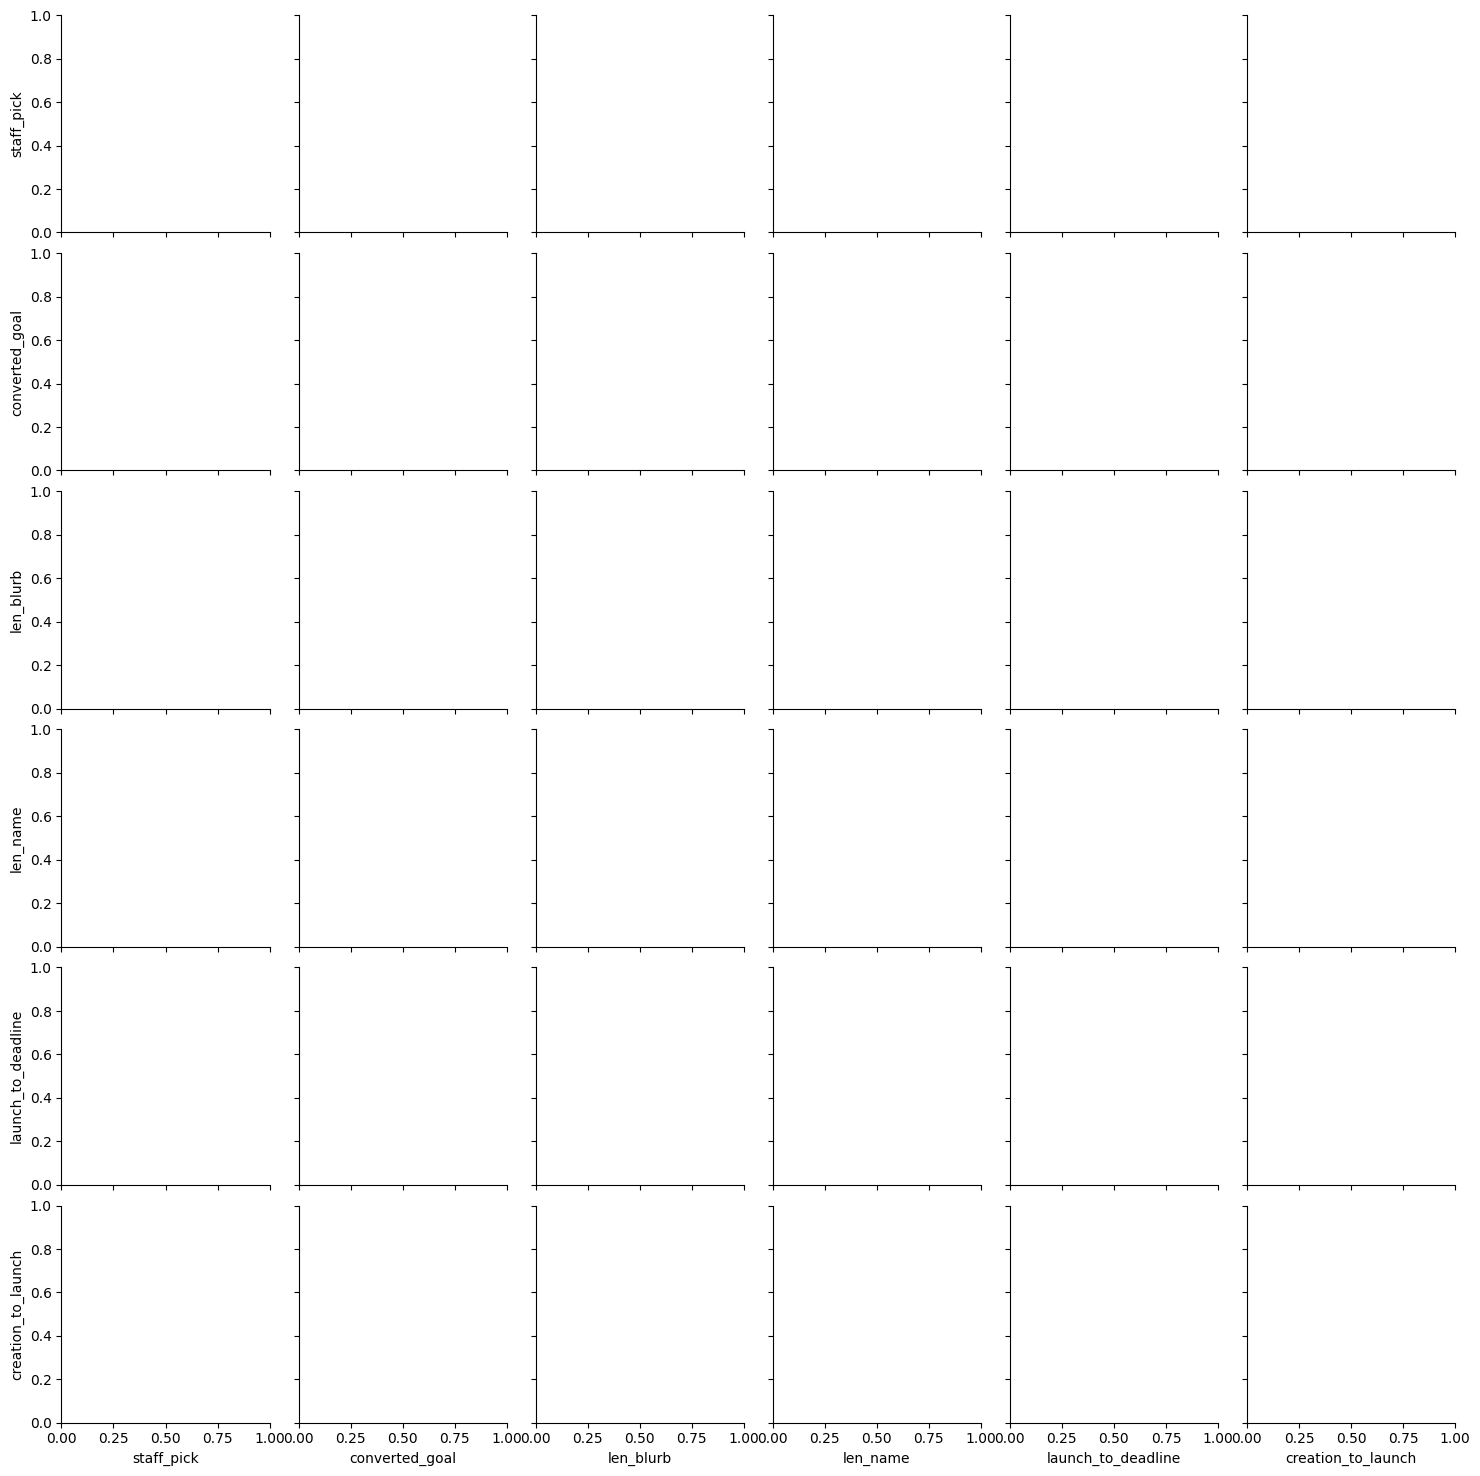

In [10]:
sns.pairplot(data[num_features])

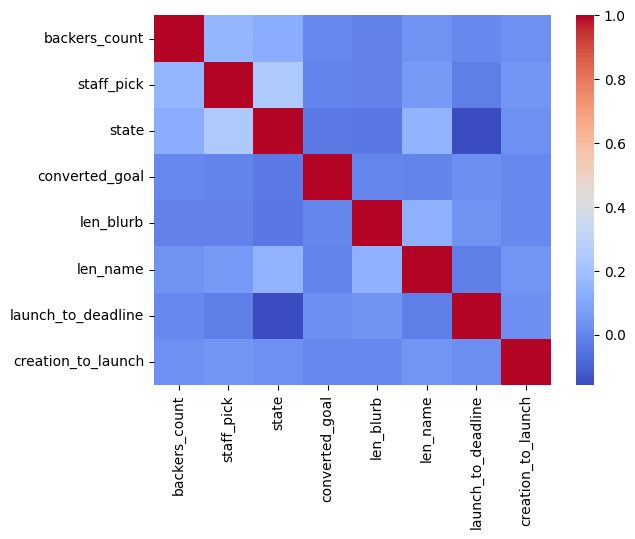

In [ ]:
# Create a correlation matrix
corr = data.corr()

# Create a heatmap using seaborn
sns.heatmap(corr, cmap="coolwarm")

# Show the plot
plt.show()